# AlexNet实现跌倒检测

In [1]:
import os
import torch
from torch.utils import data
from PIL import Image
import numpy as np
from torchvision import transforms,datasets
import shutil
from torch.nn import init
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time 

## 数据导入

In [2]:
transform=transforms.Compose([transforms.Resize(256),transforms.CenterCrop(227),transforms.ToTensor(),transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])  ])

In [5]:
train_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/dataset/dataset/train',transform=transform)
val_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/dataset/dataset/val',transform=transform)
test_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/dataset/dataset/test',transform=transform)

In [6]:
batch_size=100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

## 定义模型

In [7]:
class MyConvModule(torch.nn.Module):
    def __init__(self):
        super(MyConvModule,self).__init__()
        self.layer1=torch.nn.Sequential(torch.nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.MaxPool2d(3, 2),
                                       torch.nn.LocalResponseNorm(2))
        self.layer2=torch.nn.Sequential(torch.nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5,groups=2,padding=2),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.MaxPool2d(3, 2),
                                       torch.nn.LocalResponseNorm(2))
        self.layer3=torch.nn.Sequential(torch.nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,padding=1),
                                       torch.nn.ReLU(inplace=True))
        self.layer4=torch.nn.Sequential(torch.nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,padding=1),
                                       torch.nn.ReLU(inplace=True))
        self.layer5=torch.nn.Sequential(torch.nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,padding=1),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.MaxPool2d(3, 2))
        self.layer6=torch.nn.Sequential(torch.nn.Linear(in_features=6*6*256, out_features=4096),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.Dropout())
        self.layer7=torch.nn.Sequential(torch.nn.Linear(in_features=4096, out_features=4096),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.Dropout())
        self.layer8=torch.nn.Sequential(torch.nn.Linear(in_features=4096, out_features=3))
        
    def forward(self,X):
        X=self.layer1(X)
        X=self.layer2(X)
        X=self.layer3(X)
        X=self.layer4(X)
        X=self.layer5(X)
        X=X.view(-1,6*6*256)
        X=self.layer6(X)
        X=self.layer7(X)
        X=self.layer8(X)
        return X

## 定义训练模型函数

In [8]:
def train(net,data_loader):
    net.train()
    train_batch_num=len(data_loader)
    total_loss=0
    correct=0
    sample_num=0
    for batch_idx,(data,target) in enumerate(data_loader):
        optimizer.zero_grad()
        output=net(data)
        loss=criterion(output,target)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        prediction=torch.argmax(output,1)
        correct+=(prediction==target).sum().item()
        sample_num+=len(prediction)
    loss=total_loss/train_batch_num
    acc=correct/sample_num
    return loss,acc

## 定义测试模型函数

In [9]:
def test(net,data_loader):
    net.eval()
    test_batch_num=len(data_loader)
    total_loss=0
    correct=0
    sample_num=0
    for batch_idx,(data,target) in enumerate(data_loader):
        output=net(data)
        loss=criterion(output,target)
        total_loss+=loss.item()
        prediction=torch.argmax(output,1)
        correct+=(prediction==target).sum().item()
        sample_num+=len(prediction)
    loss=total_loss/test_batch_num
    acc=correct/sample_num
    return loss,acc

## 定义损失函数及优化器

In [10]:
net=MyConvModule()
print(net)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)
criterion=torch.nn.CrossEntropyLoss()

MyConvModule(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (layer5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=

In [11]:
list(net.parameters())

[Parameter containing:
 tensor([[[[ 4.4266e-02, -2.2899e-02, -1.6430e-02,  ..., -2.1881e-02,
            -1.9328e-02,  2.9994e-02],
           [-2.7414e-03, -4.4303e-02, -2.4546e-02,  ..., -2.4176e-02,
             1.5777e-02, -3.0880e-02],
           [-1.0160e-02, -1.6052e-02, -3.2631e-02,  ..., -4.7722e-02,
             1.3558e-02,  5.0582e-02],
           ...,
           [-5.7671e-03, -1.9296e-02,  4.5339e-02,  ...,  3.0269e-02,
            -3.3649e-02, -3.4799e-03],
           [-7.1467e-03,  1.6024e-02,  2.2511e-02,  ...,  3.4672e-02,
            -8.9158e-03, -1.1887e-03],
           [-2.6804e-02,  2.4126e-02,  3.3494e-02,  ..., -3.9301e-02,
            -7.9551e-03, -1.0905e-02]],
 
          [[ 1.5283e-02, -3.0590e-02,  4.8547e-02,  ..., -1.8629e-02,
             3.9042e-02, -8.5104e-03],
           [-5.0410e-02, -4.7552e-02,  8.0471e-03,  ...,  4.5869e-02,
             1.2336e-02, -3.7430e-02],
           [ 5.2234e-02, -9.2673e-03, -2.8311e-02,  ..., -4.8382e-02,
            -4.8

## 进行迭代

In [12]:
epoch=10
train_loss_list=[]
train_acc_list=[]
val_loss_list=[]
val_acc_list=[]
test_loss_list=[]
test_acc_list=[]
since=time.time()
for epoch in range(epoch):
    train_loss,train_acc=train(net,train_loader)
    val_loss,val_acc=test(net,val_loader)
    test_loss,test_acc=test(net,test_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print(f"epoch: {epoch} \t train_loss: {train_loss:.4f}\t"
          f" train_acc: {train_acc}\t"
          f" val_loss: {val_loss:.4f}\t val_acc:{val_acc}"
          f" test_loss: {test_loss:.4f}\t test_acc:{test_acc}")
time_elapsed=(time.time()-since)/60

epoch: 0 	 train_loss: 1.0686	 train_acc: 0.7002141327623126	 val_loss: 1.0073	 val_acc:0.7912087912087912 test_loss: 1.0253	 test_acc:0.6689895470383276
epoch: 1 	 train_loss: 0.9436	 train_acc: 0.7441113490364025	 val_loss: 0.7536	 val_acc:0.7912087912087912 test_loss: 0.8385	 test_acc:0.6689895470383276
epoch: 2 	 train_loss: 0.7176	 train_acc: 0.7441113490364025	 val_loss: 0.5398	 val_acc:0.7912087912087912 test_loss: 0.7465	 test_acc:0.6689895470383276
epoch: 3 	 train_loss: 0.5954	 train_acc: 0.7441113490364025	 val_loss: 0.5302	 val_acc:0.7912087912087912 test_loss: 0.6202	 test_acc:0.6689895470383276
epoch: 4 	 train_loss: 0.5458	 train_acc: 0.7441113490364025	 val_loss: 0.4814	 val_acc:0.7912087912087912 test_loss: 0.5886	 test_acc:0.6689895470383276
epoch: 5 	 train_loss: 0.4805	 train_acc: 0.7451820128479657	 val_loss: 0.4394	 val_acc:0.7974882260596546 test_loss: 0.4975	 test_acc:0.6829268292682927
epoch: 6 	 train_loss: 0.3499	 train_acc: 0.8308351177730193	 val_loss: 0.36

## 计算训练模型时间

In [13]:
time_elapsed

7.100173902511597

## 绘制loss曲线以及精度曲线

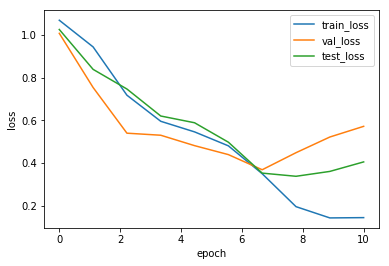

In [14]:
x=np.linspace(0,len(train_loss_list),len(test_loss_list))
plt.plot(x,train_loss_list,label="train_loss",linewidth=1.5)
plt.plot(x,val_loss_list,label="val_loss",linewidth=1.5)
plt.plot(x,test_loss_list,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

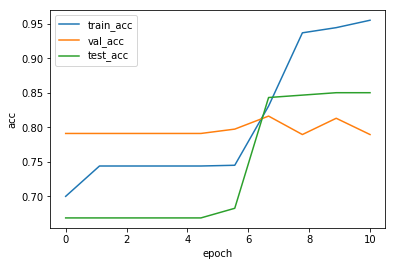

In [15]:
x=np.linspace(0,len(train_acc_list),len(test_acc_list))
plt.plot(x,train_acc_list,label="train_acc",linewidth=1.5)
plt.plot(x,val_acc_list,label="val_acc",linewidth=1.5)
plt.plot(x,test_acc_list,label="test_acc",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()